In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from data import *
from util import *
from imageio import imsave

In [3]:
x_train, x_test = load_CIFAR10()
x_train = x_train[0:100]
x_val = x_test[-100:]
x_test = x_test[0:1000]
check_range(x_train)
x_test.shape

Files already downloaded and verified
Files already downloaded and verified
0.0 0.9999000430107117


torch.Size([1000, 1, 32, 32])

In [4]:
# size of magnitude: 
# (32, 32) vs. (64, 64)
# --> non-oversampled vs. oversampled
s = (64,64) 

# size of images
si = (32,32)

(0.0, 1.0)

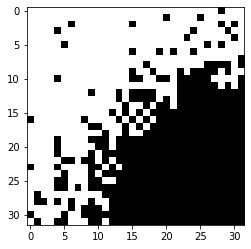

In [6]:
# code to construct our simple reference
#import scipy
#u = np.zeros((32, 32))
#u[29:, 29:] = 1
#u = scipy.ndimage.gaussian_filter(u, 16.5)
#u = (u / u.max()).astype(np.float32)
#u += 0.1 * np.random.poisson(size=(32, 32))
#u = 1-u
#u = (u > 0.5).astype(np.float32)


u = np.load('references/random/u_ours.npy')
plt.imshow(u, cmap='gray')
u.min(), u.max()


In [7]:
def reconstruct(y, u, mu=0.5, steps=500, s=(64, 64), si=(32,32)):
    x = torch.zeros(len(y), 1, *si)#+ torch.rand(len(y), 1, *si)*0.0001
    for i in range(steps):
        with torch.no_grad():
            p = phase(x + u + 1e-15, s=s, norm='backward')
            temp = torch.fft.fft2(x + u + 1e-15, s=s, norm='backward') - y*p
            grad = torch.fft.ifft2(temp, norm='backward').real[:,:,:si[0],:si[1]]
            x.data = torch.clamp(x - mu * grad, 0, 1)

    x = torch.clamp(x, 0, 1)
    return x

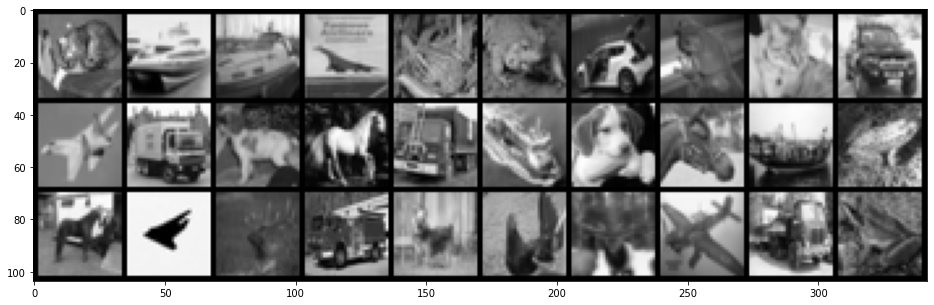

In [8]:
plt.figure(figsize=(19,5))
plt.imshow(torchvision.utils.make_grid(x_test[0:30], nrow=10 ).permute(1,2,0), )

PSNR: 78.003234 +/- 38.920218
MSE: 0.000495 +/- 0.002565
SSIM: 0.987018 +/- 0.043406


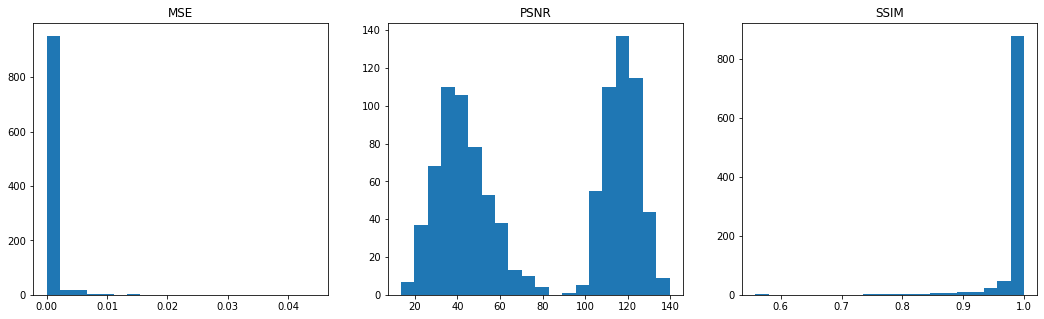

In [10]:
mse_list = []
psnr_list = []
ssim_list = []

y = magnitude(x_test + u, s=s, norm='backward')

x_rec = reconstruct(y, u, mu=1.95, si=si, s=s, steps=500)

psnr_vals = [psnr(x_rec[i, None], x_test[i, None]).item() for i in range(len(x_rec))]
mse_vals = [mse(x_rec[i, None], x_test[i, None]).item() for i in range(len(x_rec))]
ssim_vals = [ssim(x_rec[i, None], x_test[i, None]).item() for i in range(len(x_rec))]
print('PSNR: %f +/- %f' % (np.mean(psnr_vals), np.std(psnr_vals)))
print('MSE: %f +/- %f' % (np.mean(mse_vals), np.std(mse_vals)))
print('SSIM: %f +/- %f' % (np.mean(ssim_vals), np.std(ssim_vals)))

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.hist(mse_vals, bins=20, alpha=1)
plt.title('MSE')
plt.subplot(132)
plt.hist(psnr_vals, bins=20, alpha=1)
plt.title('PSNR')
plt.subplot(133)
plt.hist(ssim_vals, bins=20, alpha=1)
plt.title('SSIM')   
plt.show()

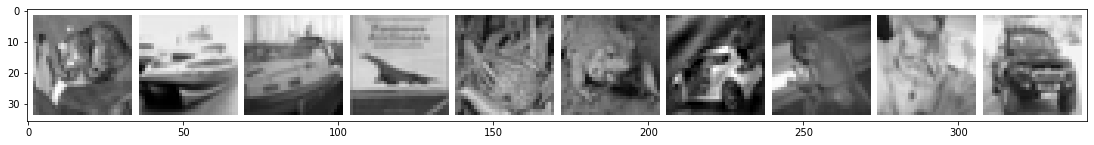

In [13]:
plt.figure(figsize=(19,5))
learned_recs_to_plot = torchvision.utils.make_grid(x_rec[0:10], nrow=10, pad_value=1).permute(1,2,0)
plt.imshow(learned_recs_to_plot)

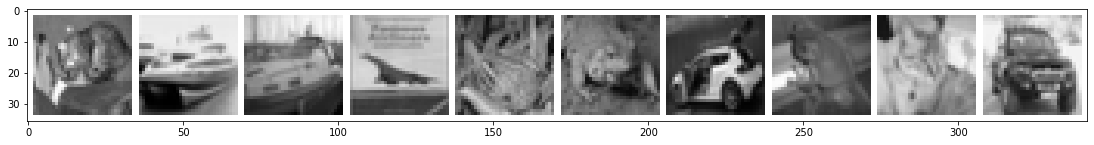

In [14]:
plt.figure(figsize=(19,5))
to_plot = torchvision.utils.make_grid(x_test[0:10], nrow=10, pad_value=1).permute(1,2,0)
plt.imshow(to_plot)

In [15]:
from skimage.registration import phase_cross_correlation
def cross_correlation(moving, fixed):
    
    if moving.shape[-1] == 3:
        moving_gray = rgb2gray(moving)
        fixed_gray = rgb2gray(fixed)
    elif moving.shape[-1] == 1:
        moving_gray = moving[..., 0]
        fixed_gray = fixed[..., 0]
    else:
        print("Image channel Error!")
    
    shift, error, diffphase = phase_cross_correlation(moving_gray, fixed_gray)
    out = np.roll(moving, -np.array(shift).astype(np.int), axis=(0, 1))
    return out, error

def register_croco(predicted_images, true_images, torch=True):
    pred_reg = np.empty(predicted_images.shape, dtype=predicted_images.dtype)

    for i in range(len(true_images)):
        if torch:
            true_image = true_images[i].transpose(1, 2, 0)
            predicted_image = predicted_images[i].transpose(1, 2, 0)
        else:
            true_image = true_images[i]
            predicted_image = predicted_images[i]

        shift_predict, shift_error = cross_correlation(predicted_image, true_image)
        rotshift_predict, rotshift_error = cross_correlation(np.rot90(predicted_image, k=2, axes=(0, 1)), true_image)
        
        if torch:
            pred_reg[i] = shift_predict.transpose(2, 0, 1) if shift_error <= rotshift_error else rotshift_predict.transpose(2, 0, 1)
        else:
            pred_reg[i] = shift_predict if shift_error <= rotshift_error else rotshift_predict
        
    return pred_reg

x_rec_reg = register_croco( x_rec.numpy(), x_test.numpy(),)

mse_vals = [mse(torch.tensor(x_rec_reg[i, None]), x_test[i, None]).item() for i in range(len(x_rec_reg))]
print('MSE: %f +/- %f' % (np.mean(mse_vals), np.std(mse_vals)))

MSE: 0.000495 +/- 0.002565


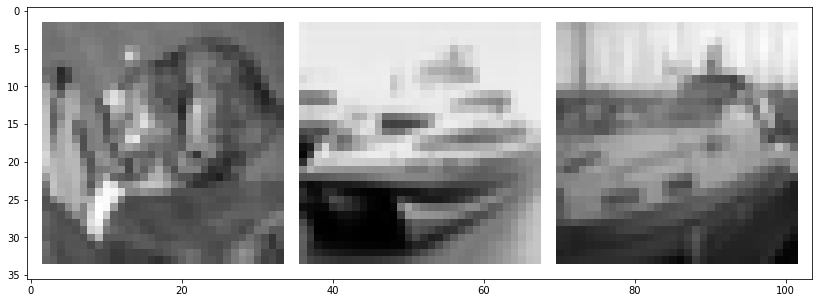

In [16]:
plt.figure(figsize=(19,5))
to_plot = torchvision.utils.make_grid(torch.tensor(x_rec_reg[:3]), nrow=6, pad_value=1).permute(1,2,0)
plt.imshow(to_plot)